# A look at EURO-CORDEX

In [1]:
# Import the libs
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
from matplotlib import pyplot as plt
from dask.distributed import Client
import dask.array as da
import dask
import dask.config
import numpy as np
from multiprocessing import Pool
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import os
import glob
from importlib import reload

In [2]:
import iris_utils.utils as utils

In [30]:
import gc
client.run(gc.collect)  # collect garbage on all workers

{'tcp://127.0.0.1:39310': 570,
 'tcp://127.0.0.1:40755': 1100,
 'tcp://127.0.0.1:45778': 1685,
 'tcp://127.0.0.1:46324': 1792}

In [41]:
import ctypes
def trim_memory() -> int:
     libc = ctypes.CDLL("libc.so.6")
     return libc.malloc_trim(0)
client.run(trim_memory)

{'tcp://127.0.0.1:36192': 1,
 'tcp://127.0.0.1:37620': 1,
 'tcp://127.0.0.1:39000': 1,
 'tcp://127.0.0.1:41095': 1}

In [3]:
# from iris_utils import mask_from_shape, merge_aeq_cubes, attribute_to_aux

In [3]:
# Some useful defaults.
projection = ccrs.epsg(3006)

In [4]:
client = Client(n_workers=4)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 32,Total memory: 62.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45493,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.50 GiB
Comm: tcp://127.0.0.1:34196,Total threads: 8
Dashboard: http://127.0.0.1:40157/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:38425,


In [6]:
# Active memory manager
client.amm.start()
client.amm.running()

True

## Region shape

In [7]:
# This file contains shapes of most countries in the world.
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-boundary-lines/
fname = "/home/sm_erhol/data/ne_10_admin_0_countries/ne_10m_admin_0_countries.shp"

In [8]:
gdf = gpd.read_file(fname)

In [9]:
# Select Sweden.
swe_shapes = gdf[gdf.SOVEREIGNT == "Sweden"].geometry
swe_mainland = swe_shapes.iloc[0].geoms[0]

## Load data
- ~~Should be all members in the end.
Only two for now.~~
- All members now.

In [10]:
# Precipitation.
base_path = "/nobackup/rossby21/sm_stran/Klimatfabrik/MidasOut/pr/"

In [11]:
files = glob.glob(base_path + "*_rcp26_*.nc")

In [12]:
# Sample files. Different GCMs.
# files = [
#     "prAdjust_NORDIC-11_ICHEC-EC-EARTH_rcp26_r12i1p1_CLMcom-CCLM4-8-17_v1_day_19491201-21001231.nc",
#     "prAdjust_NORDIC-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_19500101-21001231.nc",
#     "prAdjust_NORDIC-11_NCC-NorESM1-M_rcp26_r1i1p1_SMHI-RCA4_v1_day_19700101-21001231.nc"
#         ]

In [13]:
# paths = [os.path.join(base_path, file) for file in files]

In [14]:
cubes = iris.load(files)

**Notes on time constraints**
- Time span varies between the models.
Generally 1970 and forward is available, however, one model (MOHC-HadGEM2-ES--ICTP-RegCM4-6) start in June 1970.

In [15]:
# Add a time constraint to the loading.
time_constraint = iris.Constraint(time=lambda cell: 1971 <= cell.point.year <= 2020)

In [16]:
def extract_p(cube):
    # Add a time constraint to the loading.
    time_constraint = iris.Constraint(time=lambda cell: 1971 <= cell.point.year <= 2020,
                                     )
    return cube.extract(time_constraint)
    

In [17]:
# cubes_scattered = client.scatter(cubes)
# cubes_scattered = cubes

In [17]:
# Can we do extract in parallell?
# This seems to run on workers, so more workers are faster.
# So we use the pool.
with Pool() as p:
    cubes = p.map(extract_p, cubes)

In [18]:
#cubes = client.gather(cubes)

In [19]:
cubes = iris.cube.CubeList(cubes)

### We have to add a new dimension, since we want to concatenate.
Merge cubes works on scalar coordinates.
Since all our scalars are the same this wont work.
Approach is instead to create a new coordinate in each cube with a model identifier and concatenate along that axis.

In [20]:
reload(utils)

<module 'iris_utils.utils' from '/home/sm_erhol/dev/iris_utils/iris_utils/utils.py'>

In [21]:
utils.attribute_to_aux(cubes)

Cube 18 missing a key, skipping key.


In [22]:
removed_attrs = iris.util.equalise_attributes(cubes)

In [23]:
ref_cube = utils.merge_aeq_cubes(cubes)

Converting coordinates.
Converting coordinates.
Converting coordinates.
Converting coordinates.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting calendar.
Converting coordinates.
Converting coordinates.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting coordinates.
Converting calendar.
Converting coordinates.


/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/_lazy_data.py:277: PerformanceWarning: Increasing number of chunks by factor of 10
  result = da.stack(list(stack))


In [24]:
ref_cube.core_data()

,Array,Chunk
Bytes,35.70 GiB,73.57 MiB
Shape,"(29, 18263, 163, 111)","(1, 1066, 163, 111)"
Count,11835 Tasks,3538 Chunks
Type,float32,numpy.ndarray


Lets do another extraction of latitudes

In [37]:
lat_constraint = iris.Constraint(grid_latitude=lambda lat: 5 <= lat <= 10,
                                 grid_longitude=lambda lon: -6.375 <= lon <= 1)
with Pool() as p:
    ref_cube = ref_cube.extract(lat_constraint)

## Box plot CORDEX
What stats do we need for a box plot?
- Min
- 25th percentile
- Median
- 75th percentile
- Max

We should be able do all this in dask?

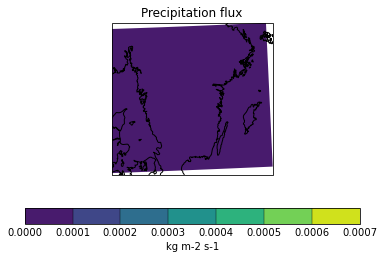

In [38]:
fig, ax = plt.subplots(subplot_kw={"projection": projection})
qplt.contourf(ref_cube[1, 1, :, :])
ax.coastlines()

In [102]:
ref_cube

Precipitation Flux (kg m-2 s-1),--,time,grid_latitude,grid_longitude
Shape,29,18263,46,68
Dimension coordinates,,,,
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
model_conf,x,-,-,-
latitude,-,-,x,x
longitude,-,-,x,x
Cell methods,,,,


In [100]:
data = ref_cube.core_data()

In [98]:
data = data.reshape((29, -1)).rechunk("auto")

In [99]:
data

dask.array<rechunk-merge, shape=(29, 57126664), dtype=float32, chunksize=(12, 2483768), chunktype=numpy.ndarray>

In [38]:
# This allows us to compute stuff for the pdf without keeping the whole data in memory.
# median = da.median(data, axis=1)
# minimum = da.min(data, axis=0).compute()
# maximum = da.max(data, axis=0).compute()
# q25 = da.percentile(data, 25).compute()[0]
# q75 = da.percentile(data, 75).compute()[0]

In [136]:
def q25_fun(a, axis):
    return np.percentile(a, 25, axis)
def q75_fun(a, axis):
    return np.percentile(a, 75, axis)
def qtiles(a, axis):
    # Which quantiles to compute on the arrays.
    return np.quantile(a, [0.25, 0.5, 0.75, 0.95], axis)

In [82]:
# Do one compute call.
# This way we don't have to do the rechunk once.
# median, maxi, mini = da.compute(
#     da.median(data, axis=1),
#     data.max(axis=1, split_every=2),
#     data.min(axis=1, split_every=2),
#     # da.apply_over_axes(q25_fun, data, 1),
#     # da.apply_over_axes(q75_fun, data, 1),
# )

In [ ]:
# Do one compute call.
# This is really all we need or? The quantiles.
quantiles = da.compute(
    da.apply_over_axes(qtiles, data, 1),
)

In [80]:
quantiles = quantiles[0].data

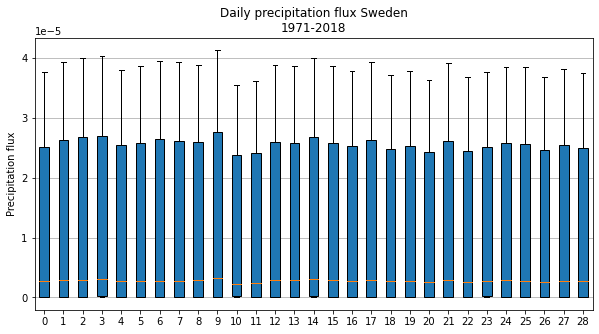

In [88]:
# Create a figure.
fig, ax = plt.subplots(figsize=(10, 5))
# Climatological data.
boxes = [
    {
    "label": i,
    "whislo": 0.,
    "q1": quantile[0],
    "med": quantile[1],
    "q3": quantile[2],
    "whishi": quantile[2] + (quantile[2] - quantile[0]) / 2,
    "fliers": []
    }
    for i, quantile in enumerate(quantiles)
]
ax.bxp(boxes, patch_artist=True, showfliers=False);
ax.set_ylabel("Precipitation flux")
ax.grid(axis="y")
ax.set_title("Daily precipitation flux Sweden\n1971-2018");

## A look at annual extremes

In [109]:
# Need to add categorical years
iris.coord_categorisation.add_year(ref_cube, "time")

In [138]:
ref_ann_max = ref_cube.aggregated_by("year", iris.analysis.MAX)

In [139]:
ref_ann_max.shape

(29, 50, 46, 68)

In [140]:
ref_ann_max = ref_ann_max.core_data().rechunk().reshape((50, -1))

In [141]:
ann_quantiles = da.compute(da.apply_over_axes(qtiles, ref_ann_max, 1))

In [142]:
ann_quantiles = ann_quantiles[0]

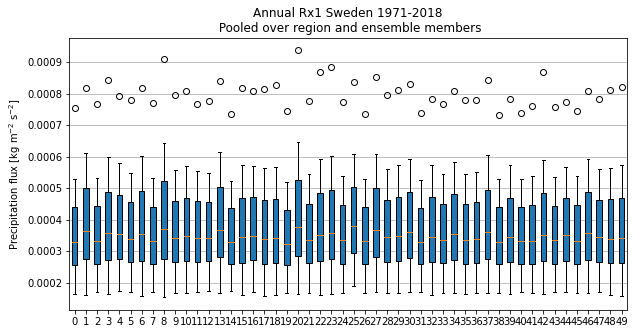

In [145]:
# Create a figure.
fig, ax = plt.subplots(figsize=(10, 5))
# Climatological data.
boxes = [
    {
    "label": i,
    "whislo": quantile[0] - (quantile[2] - quantile[0]) / 2,
    "q1": quantile[0],
    "med": quantile[1],
    "q3": quantile[2],
    "whishi": quantile[2] + (quantile[2] - quantile[0]) / 2,
    "fliers": [quantile[3]]
    }
    for i, quantile in enumerate(ann_quantiles)
]
ax.bxp(boxes, patch_artist=True, showfliers=True);
ax.set_ylabel("Precipitation flux [kg m$^{-2}$ s$^{-2}$]")
ax.grid(axis="y")
ax.set_title("Annual Rx1 Sweden 1971-2018\n Pooled over region and ensemble members");